# **Dataset and Preprocessing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/MyDrive/Aiub Courses/CVPR/animals'

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [4]:
# Load data
catagories = os.listdir(data_path)
print(catagories)

['dogs', 'panda', 'cats']


In [5]:
train_data = []

for c in catagories:
  path = os.path.join(data_path,c)
  label = catagories.index(c)
  for img in tqdm(os.listdir(path)):
    try:
      img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
      img_arr = cv2.resize(img_arr,(32,32))
      train_data.append([img_arr , label])
    except Exception as e:
      pass

print(len(train_data))

100%|██████████| 1000/1000 [00:20<00:00, 48.40it/s] 

3000


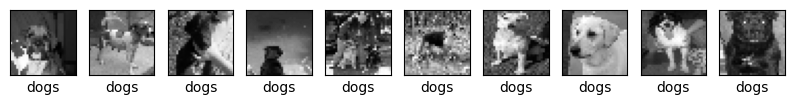

In [6]:
plt.figure(figsize=(10,3))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(train_data[i][0], cmap='gray')
  plt.xlabel(catagories[train_data[i][1]])
  plt.xticks([])
  plt.yticks([])
plt.show()

In [7]:
import random
random.shuffle(train_data)

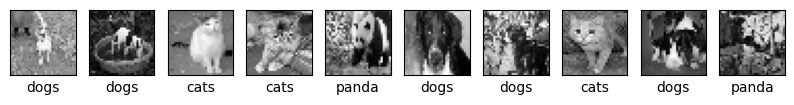

In [8]:
plt.figure(figsize=(10,3))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(train_data[i][0], cmap='gray')
  plt.xlabel(catagories[train_data[i][1]])
  plt.xticks([])
  plt.yticks([])
plt.show()

# **Model Building and Evaluation**

In [9]:
# Create folds
f1 = train_data[0:600]
f2 = train_data[600:1200]
f3 = train_data[1200:1800]
f4 = train_data[1800:2400]
f5 = train_data[2400:3000]
print(len(f1), len(f2), len(f3), len(f4), len(f5))

600 600 600 600 600


In [10]:
train_set= f1+f2+f3+f4
validation_set = f5
print(len(train_set),len(validation_set))


2400 600


In [11]:
# Initialize lists to hold distances
distances_l1 = []
distances_l2 = []

# Compute distances
for test_img in tqdm(validation_set):
    l1 = []
    l2 = []
    for train_img in train_set:
        l1.append([np.sum(np.abs(test_img[0] - train_img[0])), train_img[1]])
        l2.append([np.sqrt(np.sum((test_img[0] - train_img[0]) ** 2)), train_img[1]])

    l1.sort(key=lambda x: x[0])
    l2.sort(key=lambda x: x[0])

    distances_l1.append(l1)
    distances_l2.append(l2)

100%|██████████| 600/600 [00:37<00:00, 15.88it/s]


In [12]:
# Initialize accuracies dictionaries
accuracies_l1 = {k + 1: [] for k in range(10)}
accuracies_l2 = {k + 1: [] for k in range(10)}


In [13]:
# Compute accuracies
k_neighbours = 10

for k in range(1, k_neighbours + 1):
    correct_pred_l1 = 0
    correct_pred_l2 = 0

    for test_img, l1, l2 in zip(validation_set, distances_l1, distances_l2):
        # L1 distance
        n_neighbours_l1 = l1[:k]
        label_counts_l1 = {}
        label_min_distances_l1 = {}

        for i in range(k):
            label = n_neighbours_l1[i][1]
            distance = n_neighbours_l1[i][0]
            if label not in label_counts_l1:
                label_counts_l1[label] = 0
                label_min_distances_l1[label] = float('Inf')
            label_counts_l1[label] += 1
            label_min_distances_l1[label] = min(label_min_distances_l1[label], distance)

        max_count_l1 = max(label_counts_l1.values())
        candidates_l1 = [label for label, count in label_counts_l1.items() if count == max_count_l1]
        pred_label_l1 = min(candidates_l1, key=lambda label: label_min_distances_l1[label])

        if pred_label_l1 == test_img[1]:
            correct_pred_l1 += 1

        # L2 distance
        n_neighbours_l2 = l2[:k]
        label_counts_l2 = {}
        label_min_distances_l2 = {}

        for i in range(k):
            label = n_neighbours_l2[i][1]
            distance = n_neighbours_l2[i][0]
            if label not in label_counts_l2:
                label_counts_l2[label] = 0
                label_min_distances_l2[label] = float('Inf')
            label_counts_l2[label] += 1
            label_min_distances_l2[label] = min(label_min_distances_l2[label], distance)

        max_count_l2 = max(label_counts_l2.values())
        candidates_l2 = [label for label, count in label_counts_l2.items() if count == max_count_l2]
        pred_label_l2 = min(candidates_l2, key=lambda label: label_min_distances_l2[label])

        if pred_label_l2 == test_img[1]:
            correct_pred_l2 += 1

    accuracies_l1[k].append(correct_pred_l1 / len(validation_set))
    accuracies_l2[k].append(correct_pred_l2 / len(validation_set))

mean_accuracy_l1 = [np.mean(accuracies_l1[k]) for k in range(1, k_neighbours + 1)]
mean_accuracy_l2 = [np.mean(accuracies_l2[k]) for k in range(1, k_neighbours + 1)]


# **Results and Analysis**

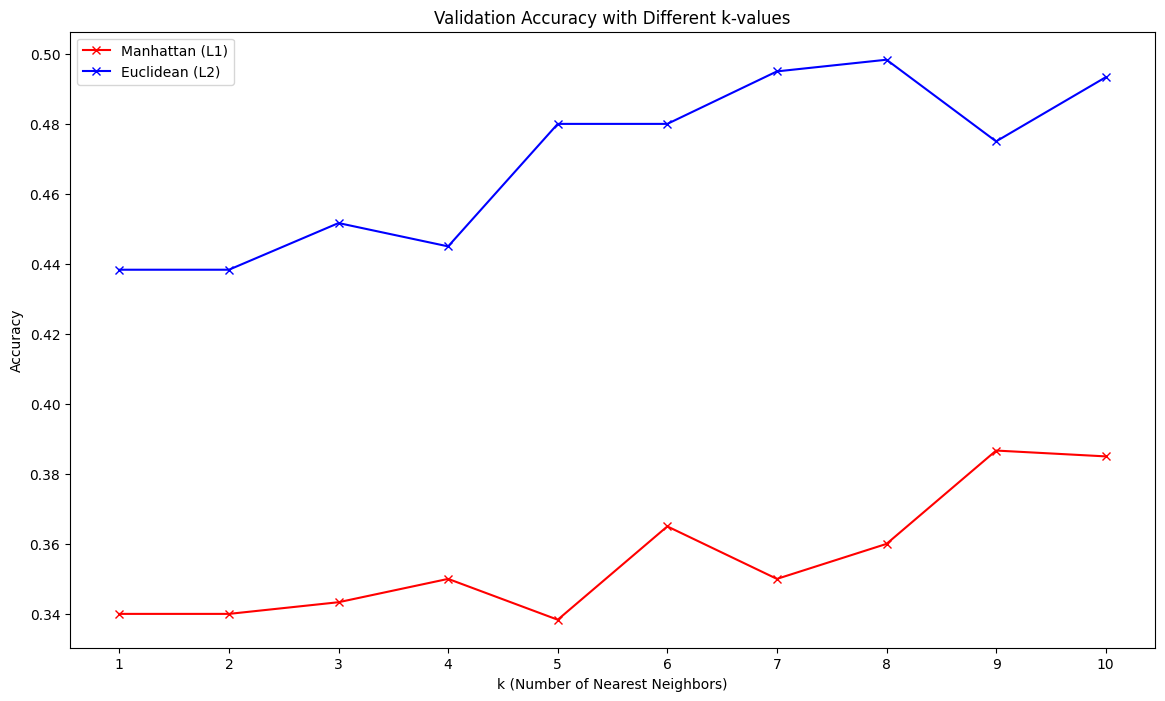

In [14]:
# Plotting results
k_values = range(1, k_neighbours + 1)

plt.figure(figsize=(14, 8))
plt.plot(k_values, mean_accuracy_l1, marker='x', linestyle='-', color='r', label='Manhattan (L1)')
plt.plot(k_values, mean_accuracy_l2, marker='x', linestyle='-', color='b', label='Euclidean (L2)')
plt.title('Validation Accuracy with Different k-values')
plt.xlabel('k (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(k_values)
plt.show()

# **Discussion**

**Comparison of Manhattan (L1) and Euclidean (L2) Performance:**

*   L1 (Manhattan Distance): lower accuracy then L2 and unstable
*   L2 (Euclidean Distance): Generally achieved higher accuracy then L1 and stable


**Dataset Characteristics:**

*   converted training images to gray-scale

**Feature Nature**

*   L1 is more unsable than L2
*   gray-scale reduces the dimensionality of the data

**Limitations & Improvements:**

*   giving access to more k values might improve the result further
*   convining L1 and L2 might give a better result



# **Top 5 predictions**

In [20]:
# Initialize lists to store predictions and corresponding distances
predictions_l1 = []
predictions_l2 = []

for test_img, l1, l2 in zip(validation_set, distances_l1, distances_l2):
    # For Manhattan (L1) distances
    n_neighbours_l1 = l1[:k_neighbours]
    label_counts_l1 = {}
    label_min_distances_l1 = {}

    for i in range(k_neighbours):
        label = n_neighbours_l1[i][1]
        distance = n_neighbours_l1[i][0]
        if label not in label_counts_l1:
            label_counts_l1[label] = 0
            label_min_distances_l1[label] = float('Inf')
        label_counts_l1[label] += 1
        label_min_distances_l1[label] = min(label_min_distances_l1[label], distance)

    max_count_l1 = max(label_counts_l1.values())
    candidates_l1 = [label for label, count in label_counts_l1.items() if count == max_count_l1]
    pred_label_l1 = min(candidates_l1, key=lambda label: label_min_distances_l1[label])

    # Store the prediction with its distances
    predictions_l1.append((test_img, pred_label_l1, l1))

    # For Euclidean (L2) distances
    n_neighbours_l2 = l2[:k_neighbours]
    label_counts_l2 = {}
    label_min_distances_l2 = {}

    for i in range(k_neighbours):
        label = n_neighbours_l2[i][1]
        distance = n_neighbours_l2[i][0]
        if label not in label_counts_l2:
            label_counts_l2[label] = 0
            label_min_distances_l2[label] = float('Inf')
        label_counts_l2[label] += 1
        label_min_distances_l2[label] = min(label_min_distances_l2[label], distance)

    max_count_l2 = max(label_counts_l2.values())
    candidates_l2 = [label for label, count in label_counts_l2.items() if count == max_count_l2]
    pred_label_l2 = min(candidates_l2, key=lambda label: label_min_distances_l2[label])

    # Store the prediction with its distances
    predictions_l2.append((test_img, pred_label_l2, l2))

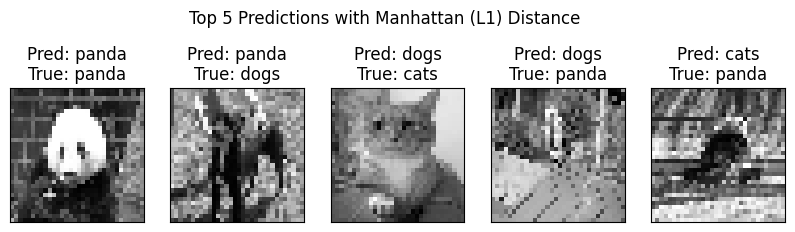

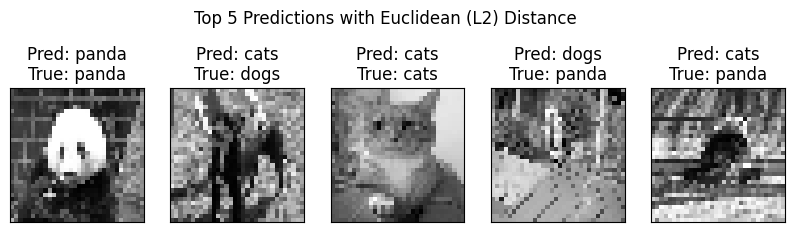

Accuracy percentage for top 5 predictions with Manhattan (L1) distance: 38.50%
Accuracy percentage for top 5 predictions with Euclidean (L2) distance: 49.33%


In [26]:
# Display the top 5 predictions
def display_top_predictions(predictions, title):
    plt.figure(figsize=(10, 3))

    for i in range(5):
        test_img, pred_label, distances = predictions[i]
        true_label = test_img[1]

        plt.subplot(1, 5, i + 1)
        plt.imshow(test_img[0], cmap='gray')
        plt.title(f'Pred: {catagories[pred_label]}\nTrue: {catagories[true_label]}')
        plt.xticks([])
        plt.yticks([])

    plt.suptitle(title)
    plt.show()

# Display predictions for L1 and L2 distances
display_top_predictions(predictions_l1, "Top 5 Predictions with Manhattan (L1) Distance")
display_top_predictions(predictions_l2, "Top 5 Predictions with Euclidean (L2) Distance")

def calculate_accuracy_percentage(predictions):
    correct_predictions = 0
    total_predictions = len(predictions)

    for test_img, pred_label, _ in predictions:
        true_label = test_img[1]
        if pred_label == true_label:
            correct_predictions += 1

    accuracy_percentage = (correct_predictions / total_predictions) * 100
    return accuracy_percentage

# Calculate accuracy for top 5 predictions with L1 and L2 distances
accuracy_percentage_l1 = calculate_accuracy_percentage(predictions_l1)
accuracy_percentage_l2 = calculate_accuracy_percentage(predictions_l2)

print(f"Accuracy percentage for top 5 predictions with Manhattan (L1) distance: {accuracy_percentage_l1:.2f}%")
print(f"Accuracy percentage for top 5 predictions with Euclidean (L2) distance: {accuracy_percentage_l2:.2f}%")